# 🧠 Fase 3: Modelado, Evaluación e Interpretación

**Objetivo:** Entrenar el modelo final con los hiperparámetros optimizados, evaluarlo con métricas profesionales y entender qué características son las más influyentes en sus predicciones.

### Paso 1: Carga y Preparación Final de Datos

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Carga los datos que ya procesaste
print("Cargando datos preprocesados...")
df_processed = pd.read_parquet('../data/processed/preprocessed_data.parquet')

# Define tus features (X) y tu target (y)
X = df_processed.drop('Target', axis=1)
y_raw = df_processed['Target']

# Codificar la variable objetivo (Target) a valores numéricos
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

# Guardar las clases para usarlas en las visualizaciones
class_names = label_encoder.classes_
print(f"Clases codificadas: {dict(zip(class_names, range(len(class_names))))}")

# Convertir todas las columnas de X a tipos de datos que XGBoost entiende (evitar errores)
X = pd.get_dummies(X, drop_first=True)

# Divide en entrenamiento y prueba (¡usa stratify!)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Datos listos. Formas: X_train={X_train.shape}, X_test={X_test.shape}")

Cargando datos preprocesados...
Clases codificadas: {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}
Datos listos. Formas: X_train=(3539, 52), X_test=(885, 52)


### Paso 2: Modelo Final (Entrenamiento con los Mejores Hiperparámetros)

In [2]:
from xgboost import XGBClassifier

# Inicializa el modelo con los MEJORES parámetros que ya encontraste
best_params = {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}

# Para problemas multiclase, el objetivo y la métrica cambian
model_final = XGBClassifier(
    objective='multi:softprob',  # Objetivo para clasificación multiclase
    num_class=len(class_names),    # Número de clases a predecir
    eval_metric='mlogloss',        # Métrica de evaluación para multiclase
    use_label_encoder=False,
    **best_params
)

# Entrena el modelo final
print("Entrenando el modelo final con los mejores hiperparámetros...")
model_final.fit(X_train, y_train)
print("¡Modelo final entrenado!")

Entrenando el modelo final con los mejores hiperparámetros...


/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [09:05:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


¡Modelo final entrenado!


### Paso 3: Evaluación Profesional del Modelo

--- Classification Report ---
              precision    recall  f1-score   support

     Dropout       0.82      0.75      0.78       284
    Enrolled       0.52      0.48      0.50       159
    Graduate       0.82      0.88      0.85       442

    accuracy                           0.77       885
   macro avg       0.72      0.70      0.71       885
weighted avg       0.76      0.77      0.76       885


--- Matriz de Confusión ---


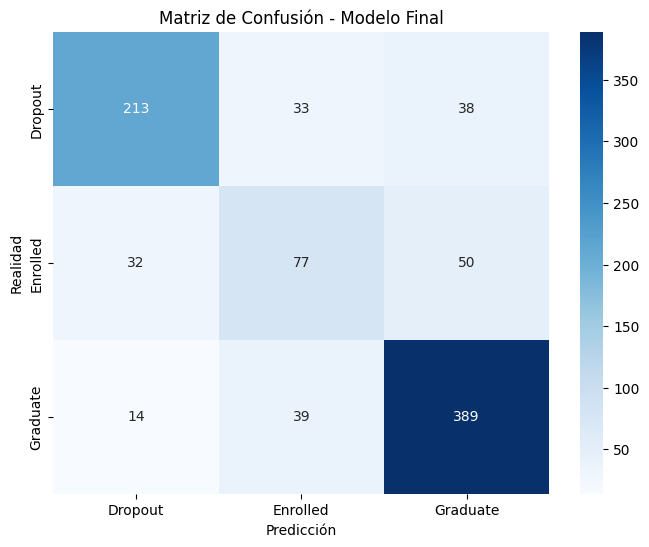


--- Curva ROC y AUC (One-vs-Rest) ---
AUC para la clase 'Dropout': 0.9185
AUC para la clase 'Enrolled': 0.8279
AUC para la clase 'Graduate': 0.9298

AUC Promedio Ponderado (OvR): 0.9079


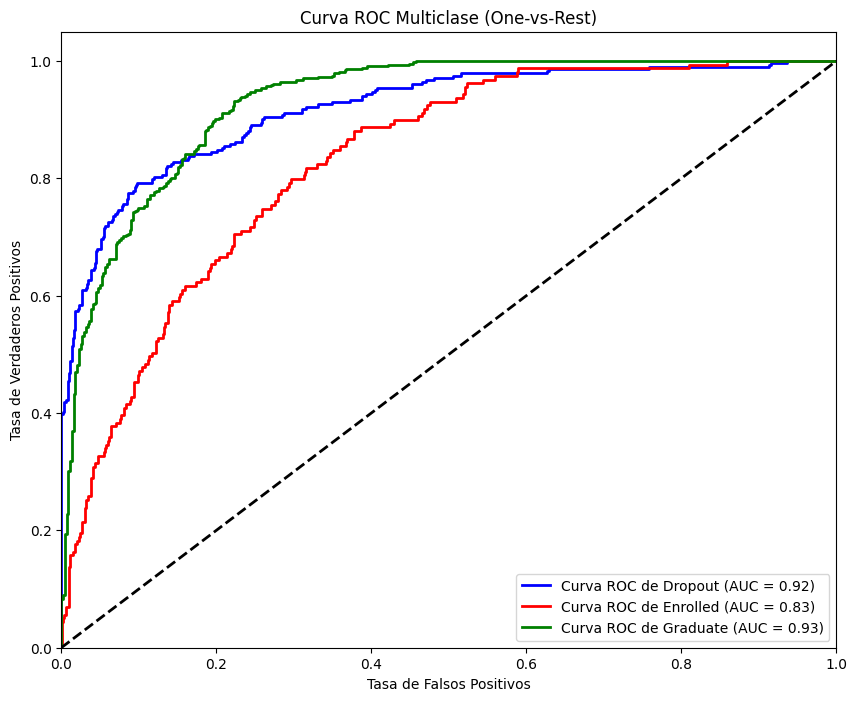

In [3]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Realiza predicciones en el conjunto de prueba
y_pred = model_final.predict(X_test)
y_pred_proba = model_final.predict_proba(X_test) # Probabilidades para cada clase

# --- 1. Classification Report ---
print("--- Classification Report ---")
report = classification_report(y_test, y_pred, target_names=class_names)
print(report)

# --- 2. Matriz de Confusión ---
print("\n--- Matriz de Confusión ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión - Modelo Final')
plt.savefig('../app/static/imagenes/7_matriz_confusion.png') # Guarda el Exhibit
plt.show()

# --- 3. Curva ROC y AUC (para multiclase, se hace One-vs-Rest) ---
print("\n--- Curva ROC y AUC (One-vs-Rest) ---")

# Calcular AUC para cada clase
roc_auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average=None)
for i, class_name in enumerate(class_names):
    print(f'AUC para la clase \'{class_name}\': {roc_auc_ovr[i]:.4f}')

# Calcular AUC promedio ponderado
roc_auc_avg = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
print(f'\nAUC Promedio Ponderado (OvR): {roc_auc_avg:.4f}')

plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
for i, color in zip(range(len(class_names)), colors):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'Curva ROC de {class_names[i]} (AUC = {roc_auc_ovr[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC Multiclase (One-vs-Rest)')
plt.legend(loc="lower right")
plt.savefig('../app/static/imagenes/8_curva_roc.png') # Guarda el Exhibit
plt.show()

### Paso 4: Interpretación Final (Feature Importance)

--- Top 10 Características Más Importantes ---
                                Feature  Importance
37                  Ratio_Aprobacion_S2    0.325574
16              Tuition fees up to date    0.066013
36                  Ratio_Aprobacion_S1    0.032680
22  Curricular units 1st sem (enrolled)    0.031983
46                        Eficiencia_S2    0.025760
18                   Scholarship holder    0.023784
30  Curricular units 2nd sem (approved)    0.018318
41                Socioeconomico_Riesgo    0.018303
28  Curricular units 2nd sem (enrolled)    0.017676
3                                Course    0.017169


/var/folders/2q/p20x_89x4xgcp2rqzvyzpb840000gn/T/ipykernel_83000/764232087.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
/var/folders/2q/p20x_89x4xgcp2rqzvyzpb840000gn/T/ipykernel_83000/764232087.py:19: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.savefig('../app/static/imagenes/9_feature_importance.png') # Guarda el Exhibit
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


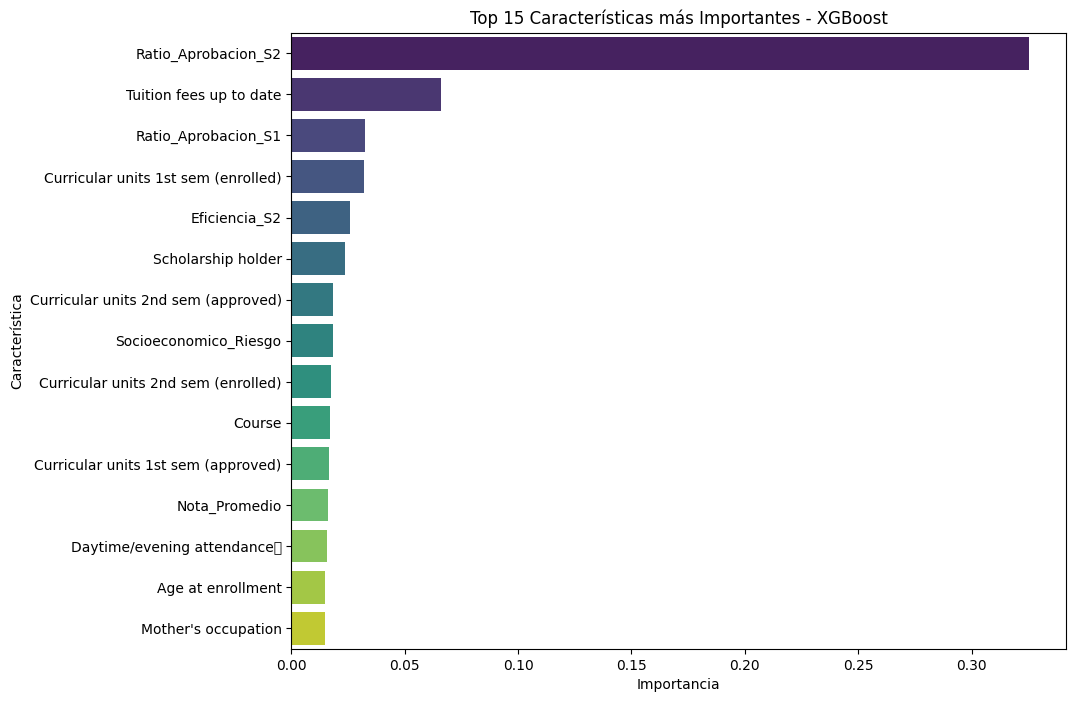

In [4]:
# Obtener la importancia de las características
importances = model_final.feature_importances_
feature_names = X.columns

# Crear un DataFrame para visualizar mejor
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Mostrar las 10 más importantes
print("--- Top 10 Características Más Importantes ---")
print(feature_importance_df.head(10))

# Graficar
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('Top 15 Características más Importantes - XGBoost')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.savefig('../app/static/imagenes/9_feature_importance.png') # Guarda el Exhibit
plt.show()